In [1]:
import glob
import os
import sys

%matplotlib widget

import timeloopfe.v4 as tl
from joblib import Parallel, delayed

# add workspace root directory to Python path for local imports
workspace_root = '/home/workspace'
if workspace_root not in sys.path:
    sys.path.append(workspace_root)

from scripts.plots import *
from scripts.utils import *

In [5]:
ARCHITECTURE_CHOICE = 'simple_w_temp_stages'
SUB_ARCHITECTURES = ['AQFP', 'CMOS_7nm']

WORKLOAD_CHOICE = 'matmul_basic'
LAYER_CHOICE = 'matmul_basic.yaml'
BATCH_SIZE = 8

if not SUB_ARCHITECTURES:
    SUB_ARCHITECTURES = [os.path.basename(f).rsplit('.', 1)[0] for f in glob.glob(f'../models/architectures/{ARCHITECTURE_CHOICE}/*.yaml')]

print(f'Architecture: {ARCHITECTURE_CHOICE} {", ".join(SUB_ARCHITECTURES)}')
print(f'Workload: {WORKLOAD_CHOICE} {LAYER_CHOICE}')

Architecture: simple_w_temp_stages AQFP, CMOS_7nm
Workload: matmul_basic matmul_basic.yaml


In [6]:
kwargs = dict(
    architecture=ARCHITECTURE_CHOICE,
    workload=WORKLOAD_CHOICE,
    layer=LAYER_CHOICE,
    n_macs=1,
    reg_depth=128,
    reg_width=16
)

results_wo_cooling = {}
results_wo_cooling = Parallel(n_jobs=-1)(delayed(generate_result)(sub_architecture, BATCH_SIZE, add_cooling=False, **kwargs) for sub_architecture in SUB_ARCHITECTURES)
results_wo_cooling = {sub_architecture: result for sub_architecture, result in zip(SUB_ARCHITECTURES, results_wo_cooling)}
energy_per_compute_wo_cooling = {k:v.per_compute('per_component_energy') for k,v in results_wo_cooling.items()}
area_wo_cooling = {k:v.per_component_area for k,v in results_wo_cooling.items()}

results_w_cooling = {}
results_w_cooling = Parallel(n_jobs=-1)(delayed(generate_result)(sub_architecture, BATCH_SIZE, **kwargs) for sub_architecture in SUB_ARCHITECTURES)
results_w_cooling = {sub_architecture: result for sub_architecture, result in zip(SUB_ARCHITECTURES, results_w_cooling)}
energy_per_compute_w_cooling = {k:v.per_compute('per_component_energy') for k,v in results_w_cooling.items()}
area_w_cooling = {k:v.per_component_area for k,v in results_w_cooling.items()}


In [7]:
results_w_cooling["AQFP"].per_component_energy

{'mac': 8.589934592e-06,
 'register': 1.7179869184e-05,
 'cryocable': 13.7438953472,
 'cold->hot': 0.003582002724864,
 'hot->cold': 0.00031439160606719997,
 'main memory': 0.003375844294656}

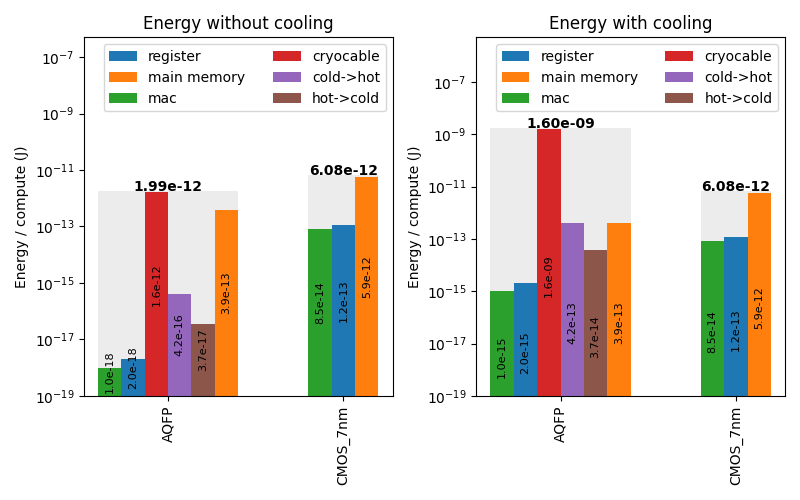

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(8, 5))
bar_side_by_side(energy_per_compute_wo_cooling, ylabel="Energy / compute (J)", title="Energy without cooling", yscale="log", ax=axs[0], legend_ncol=2, missing_ok=True, log_bottom= 5e-19)
bar_side_by_side(energy_per_compute_w_cooling, ylabel="Energy / compute (J)", title="Energy with cooling", yscale="log", ax=axs[1], legend_ncol=2, missing_ok=True)

axs[1].set_ylim(bottom=1e-19, top=5e-6)
axs[0].set_ylim(bottom=1e-19, top=5e-7)
plt.tight_layout()

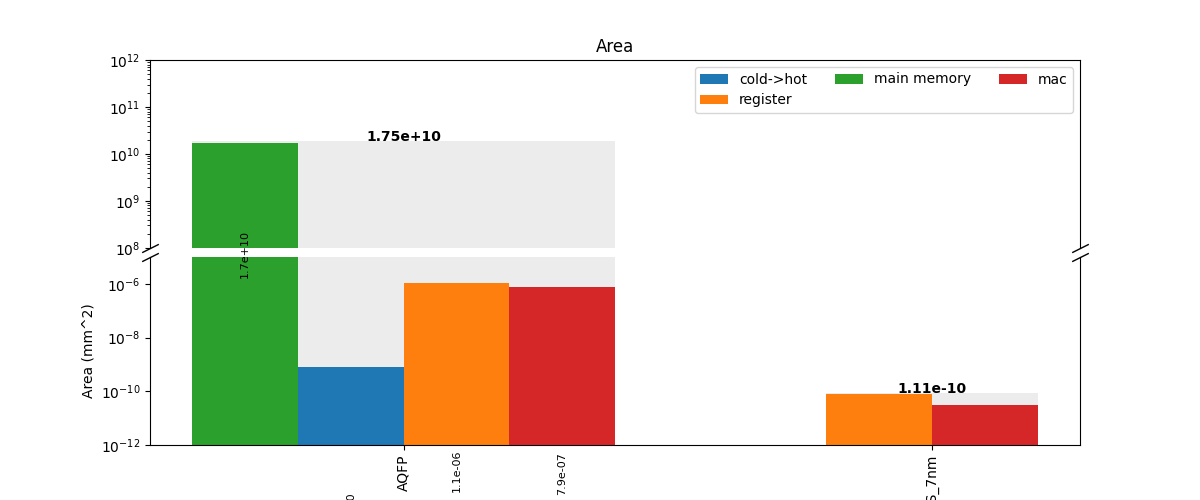

In [17]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 5))
fig.subplots_adjust(hspace=0.05)

bar_side_by_side(area_w_cooling, title="Area", yscale="log", missing_ok=True, ax=ax1, legend_ncol=3)
bar_side_by_side(area_w_cooling, ylabel="Area (mm^2)", yscale="log", missing_ok=True, ax=ax2, legend_off = True)

ax1.set_ylim(1e8, 1e12)
ax2.set_ylim(1e-12, 1e-5)

ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.tick_params(bottom=False)

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

## Small register and single MAC

In [ ]:
kwargs = dict(
    architecture=ARCHITECTURE_CHOICE,
    workload=WORKLOAD_CHOICE,
    layer=LAYER_CHOICE,
    n_macs=1,
    reg_depth=128,
    reg_width=16
)

results = {}
results = Parallel(n_jobs=-1)(delayed(generate_result)(sub_architecture, BATCH_SIZE, **kwargs) for sub_architecture in SUB_ARCHITECTURES)
results = {sub_architecture: result for sub_architecture, result in zip(SUB_ARCHITECTURES, results)}
energy_per_compute = {k:v.per_compute('per_component_energy') for k,v in results.items()}
area = {k:v.per_component_area for k,v in results.items()}
[area[k].pop("main memory", None) for k in area.keys()] # remove main memory from area because it's capacity was arbitrarily set

[17454747090.944, None]

In [153]:
#area['AQFP'].pop("main memory", None)
area

{'AQFP': {'cold->hot': 1.6e-09, 'register': 1.13664e-06, 'mac': 7.9196e-07},
 'CMOS_7nm': {'register': 7.8943375e-11, 'mac': 3.1616625e-11}}

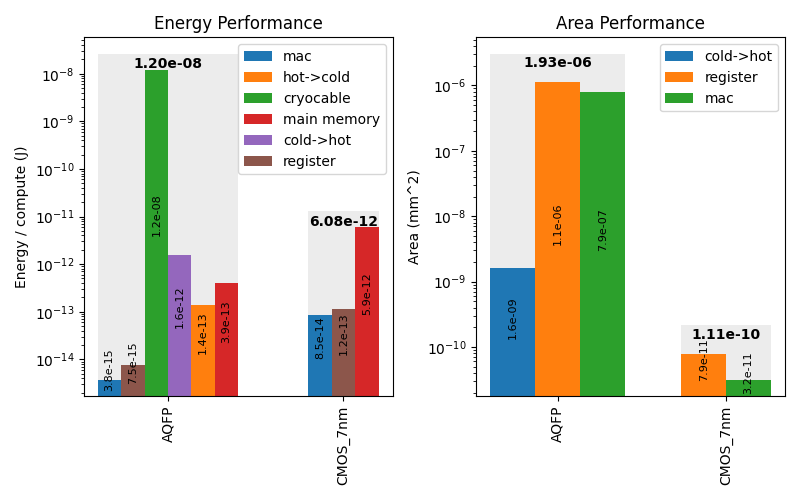

In [173]:
fig, axs = plt.subplots(1, 2, figsize=(8, 5))
nb_bar_side_by_side(energy_per_compute, ylabel="Energy / compute (J)", title="Energy Performance", yscale="log", log_bottom=1e-14, ax=axs[0], legend_ncol=1, missing_ok=True, total_label_multiplier=1.1, gray_multiplier=2.2)
nb_bar_side_by_side(area, ylabel="Area (mm^2)", title="Area Performance", yscale="log", log_bottom=5e-11, ax=axs[1], legend_ncol=1, missing_ok=True, total_label_multiplier=1.7, gray_multiplier=2.7)
plt.tight_layout()


## Larger register and single MAC

In [18]:
kwargs = dict(
    architecture=ARCHITECTURE_CHOICE,
    workload=WORKLOAD_CHOICE,
    layer=LAYER_CHOICE,
    n_macs=1,
    reg_depth=128*4,
    reg_width=16
)

results = {}
results = Parallel(n_jobs=-1)(delayed(generate_result)(sub_architecture, BATCH_SIZE, **kwargs) for sub_architecture in SUB_ARCHITECTURES)
results = {sub_architecture: result for sub_architecture, result in zip(SUB_ARCHITECTURES, results)}
energy_per_compute = {k:v.per_compute('per_component_energy') for k,v in results.items()}
area = {k:v.per_component_area for k,v in results.items()}

posx and posy should be finite values
posx and posy should be finite values


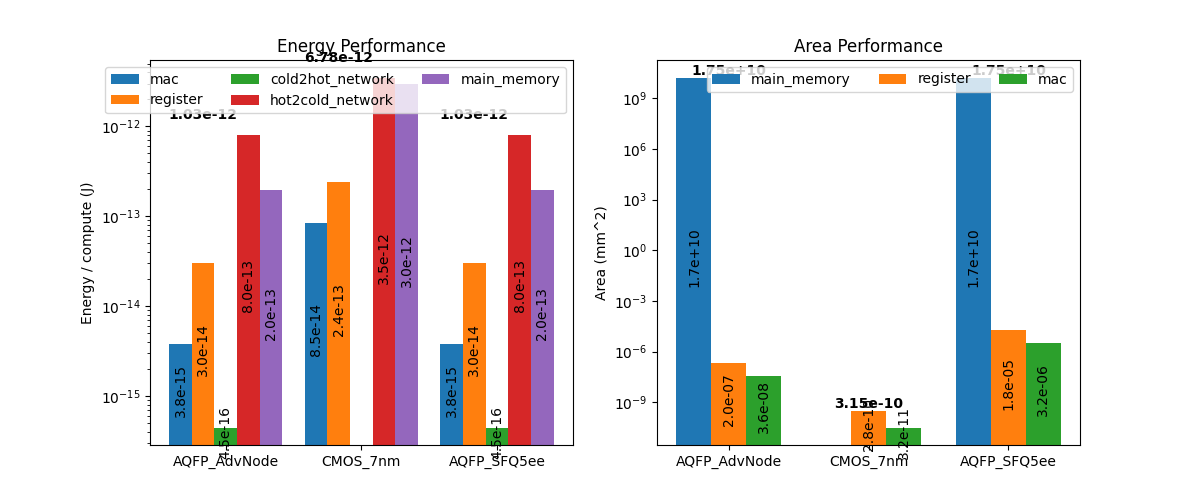

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
bar_side_by_side(energy_per_compute, ylabel="Energy / compute (J)", title="Energy Performance", yscale="log", ax=axs[0], legend_ncol=3, missing_ok=True)
bar_side_by_side(area, ylabel="Area (mm^2)", title="Area Performance", yscale="log", ax=axs[1], legend_ncol=3, missing_ok=True)

## Large register and many MACs

In [10]:
kwargs = dict(
    architecture=ARCHITECTURE_CHOICE,
    workload=WORKLOAD_CHOICE,
    layer=LAYER_CHOICE,
    n_macs=16,
    reg_depth=128*4,
    reg_width=16
)

results = {}
results = Parallel(n_jobs=-1)(delayed(generate_result)(sub_architecture, BATCH_SIZE, add_cooling=False, **kwargs) for sub_architecture in SUB_ARCHITECTURES)
results = {sub_architecture: result for sub_architecture, result in zip(SUB_ARCHITECTURES, results)}
energy_per_compute = {k:v.per_compute('per_component_energy') for k,v in results.items()}
area = {k:v.per_component_area for k,v in results.items()}

posx and posy should be finite values
posx and posy should be finite values


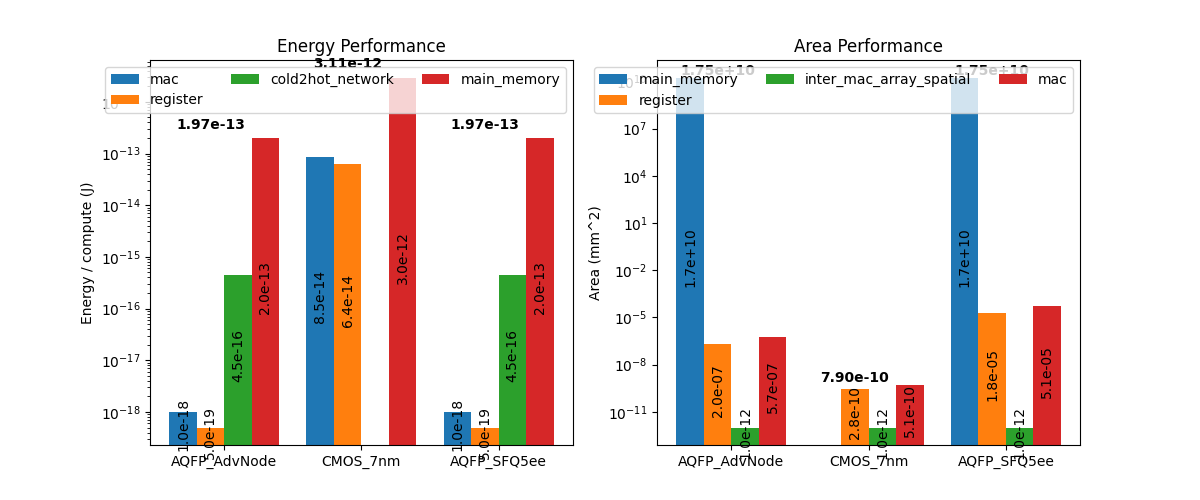

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
bar_side_by_side(energy_per_compute, ylabel="Energy / compute (J)", title="Energy Performance", yscale="log", ax=axs[0], legend_ncol=3, missing_ok=True)
bar_side_by_side(area, ylabel="Area (mm^2)", title="Area Performance", yscale="log", ax=axs[1], legend_ncol=3, missing_ok=True)